In [3]:
from finrl_slim.preprocessing.yahoodownloader import YahooDownloader
from finrl_slim.preprocessing.preprocessors import data_split
import pandas as pd

In [4]:
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2022-01-01'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-01-01'
TICKER_LIST = ['GOOG']
stock_dims = len(TICKER_LIST)
state_dims = 1 + (2 * stock_dims)

In [5]:
import os
if os.path.exists('yahoo_data.csv'):
    print("Loading cached yahoo data...")
    df = pd.read_csv('yahoo_data.csv')
else:
    print("Downloading new yahoo data...")
    df = YahooDownloader(
        start_date = TRAIN_START_DATE,
        end_date = TEST_END_DATE,
        ticker_list=TICKER_LIST,
        
    ).fetch_data()
    df.to_csv("yahoo_data.csv")

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (756, 8)


In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(['date','tic'], ignore_index=True)

In [7]:
train_data = data_split(df, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(df, TEST_START_DATE, TEST_END_DATE)
print("TRAIN SHAPE: ", train_data.shape)
print("TRADE SHAPE: ", trade_data.shape)

TRAIN SHAPE:  (505, 8)
TRADE SHAPE:  (251, 8)


In [8]:
from finrl_slim.env import StockTradingEnv

In [10]:
# initialise single stock (GOOG) environment
env_train = StockTradingEnv(
    df=train_data,
    stock_dims=1,
    hmax=100,
    initial_amount=10000,
    num_stock_shares=[0],
    buy_cost_pct=0.001,
    sell_cost_pct=0.001,
    tech_indicator_list=[],
)

In [11]:
from finrl_slim.agent import DRLAgent

In [12]:
agent = DRLAgent(env=env_train)

In [13]:
model_ppo = agent.get_model()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
from finrl_slim.config import RESULTS_DIR
from stable_baselines3.common.logger import configure
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv"])
model_ppo.set_logger(new_logger_ppo)

Logging to results/ppo


In [46]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=10000)

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 505          |
|    ep_rew_mean          | 0            |
| time/                   |              |
|    fps                  | 1            |
|    iterations           | 1            |
|    time_elapsed         | 1485         |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0014059688 |
|    clip_fraction        | 0.00981      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.53        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0194      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000901    |
|    reward               | 0.0          |
|    std                  | 1.14         |
|    value_loss           | 0.000303     |
------------------------------------------
-----------

In [44]:
import pandas as pd
baseline = pd.read_csv("baseline_daily_return.csv")
baseline.rename(columns={'daily_return': 'baseline_return'}, inplace=True)
model = pd.read_csv("model_daily_return.csv")
model.rename(columns={'daily_return': 'model_return'}, inplace=True)

<Axes: xlabel='date'>

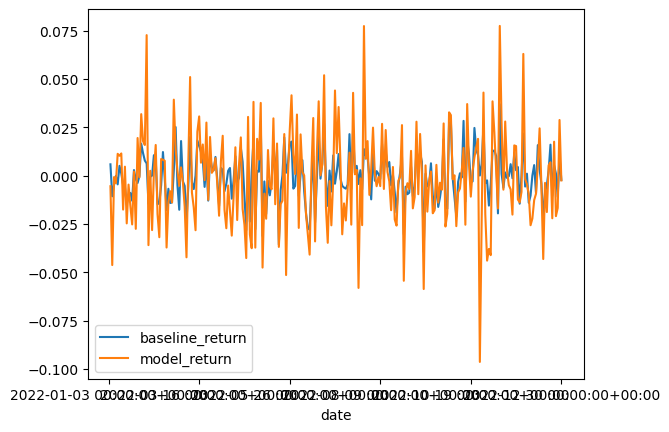

In [45]:
model.merge(baseline, on='date').plot(x='date', y=['baseline_return', 'model_return'])